In [178]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [179]:
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

In [180]:
df=pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv',sep=',')

In [181]:
df.tail()

,Date,Country,Confirmed,Recovered,Deaths
12277,2020-03-30,Venezuela,135,39,3
12278,2020-03-30,Vietnam,203,55,0
12279,2020-03-30,West Bank and Gaza,116,18,1
12280,2020-03-30,Zambia,35,0,0
12281,2020-03-30,Zimbabwe,7,0,1


Put data into ssql lite to take advantages of window functions

In [182]:
import sqlite3
conn = sqlite3.connect('Covid-19.db')
c = conn.cursor()

In [183]:
c.execute('CREATE TABLE IF NOT EXISTS covid_cases (Date text, Country text,Confirmed number,Recovered number,Deaths number)')
conn.commit()

In [184]:
df.to_sql('covid_cases', conn, if_exists='replace', index = False)

In [185]:
c.execute("""SELECT Date,Country,Confirmed,Recovered,Deaths,
    DENSE_RANK()Over(PARTITION BY Country order by Date Asc) as Days
    from covid_cases  where Confirmed<>0""")


In [186]:
results = c.fetchall()
#print(results[0:2])
df = pd.DataFrame(results, columns=['Date','Country','Confirmed','Recovered','Deaths','Days'])    
#print (df1.head(3))

In [187]:
c.close()

In [188]:
df['Date']=pd.to_datetime(df['Date'])

In [189]:
#get top 100 confirmed cases and find the countries 
df_max=df.sort_values(['Confirmed'],ascending=False)[:101]

In [190]:
countries=df_max['Country'].unique()

In [191]:
countries

array(['US', 'Italy', 'Spain', 'China', 'Germany', 'France', 'Iran'],
      dtype=object)

In [192]:

df=df.sort_values(['Date'],ascending=False)

In [193]:
#get a dataframe for each country
list_top_df=[]
for c in countries:
    #put name
    name='df_'+c
    #print(name)  
    list_top_df.append(df[(df['Country']==c)])  


In [194]:
for l in list_top_df:
    l['Daily_Infection']=l['Confirmed']-l['Confirmed'].shift(-1)
    l['Daily_Death']=l['Deaths']-l['Deaths'].shift(-1)
    l['Daily_Recovery']=l['Recovered']-l['Recovered'].shift(-1)

In [195]:
import numpy as np
list_colors=[]
for i in range(0,len(list_top_df)):
    color = list(np.random.choice(range(256), size=3))
    color=[c/256 for c in color]      
    list_colors.append(color)      
        
          
    
print(list_colors)

[[0.921875, 0.92578125, 0.6640625], [0.6953125, 0.453125, 0.43359375], [0.5703125, 0.33203125, 0.2578125], [0.53125, 0.69140625, 0.90625], [0.08203125, 0.55859375, 0.9921875], [0.4609375, 0.18359375, 0.3203125], [0.33984375, 0.15625, 0.18359375]]


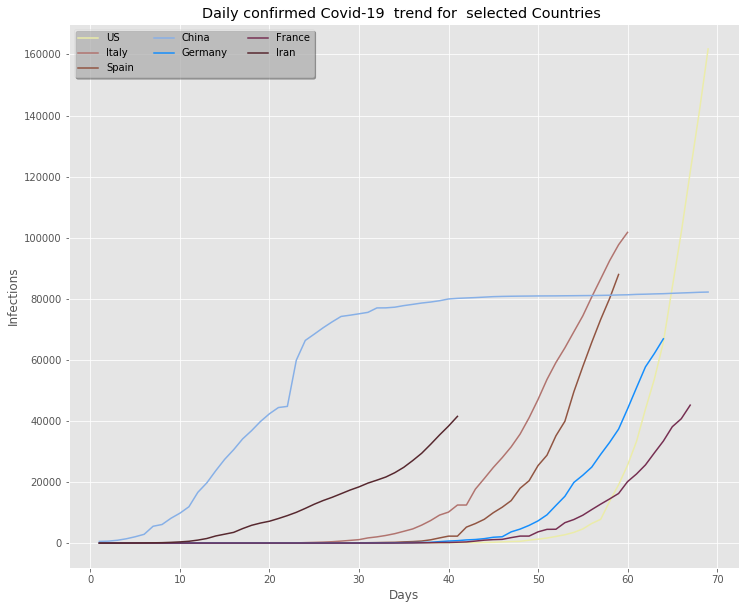

In [196]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Confirmed'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily confirmed Covid-19  trend for  selected Countries ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

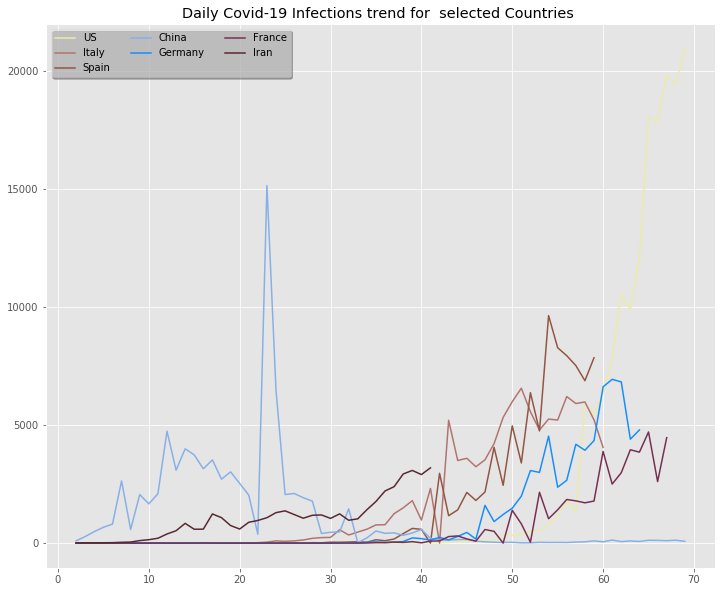

In [197]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Infection'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily Covid-19 Infections trend for  selected Countries ')
    leg.get_frame().set_alpha(0.5)
plt.savefig('Daily_Infections.png')

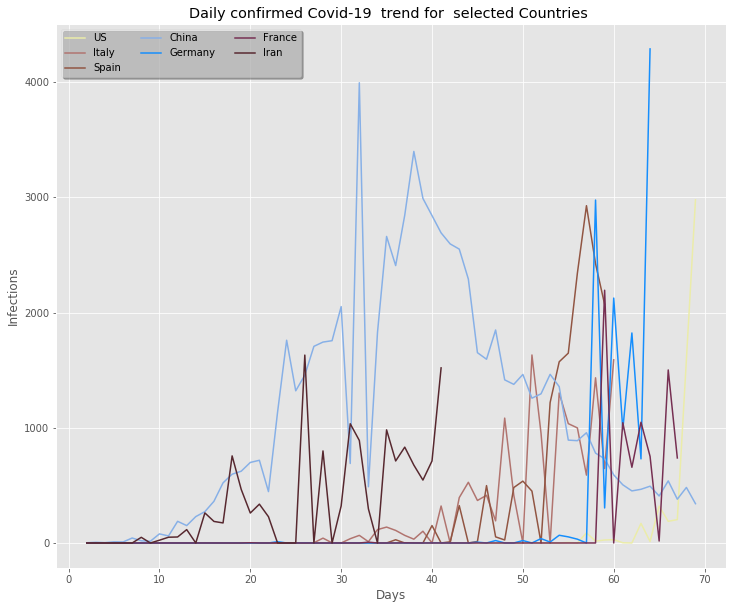

In [198]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Recovery'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily confirmed Covid-19  trend for  selected Countries ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

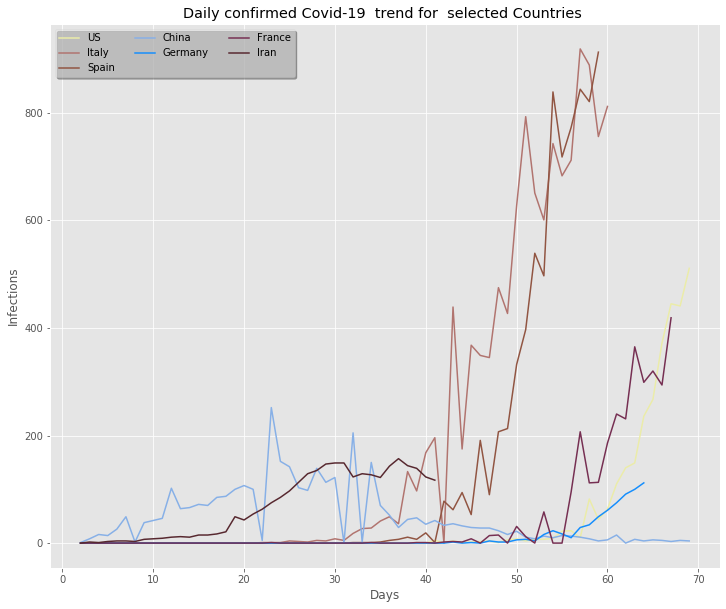

In [199]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Death'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily confirmed Covid-19  trend for  selected Countries ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

###### East Africa Countries

In [200]:
#countries=df_max['Country'].unique()
countries=['Uganda','Kenya','Tanzania','Rwanda']

In [201]:
countries

['Uganda', 'Kenya', 'Tanzania', 'Rwanda']

In [202]:
import numpy as np
list_colors=[]
for i in range(0,len(list_top_df)):
    color = list(np.random.choice(range(256), size=3))
    color=[c/256 for c in color]      
    list_colors.append(color)      
        
          
    
print(list_colors)

[[0.765625, 0.5234375, 0.9765625], [0.7578125, 0.84375, 0.1015625], [0.08984375, 0.67578125, 0.20703125], [0.328125, 0.86328125, 0.28515625], [0.796875, 0.48828125, 0.203125], [0.01953125, 0.1484375, 0.75], [0.6875, 0.375, 0.10546875]]


In [203]:
#get a dataframe for each country
list_top_df=[]
for c in countries:
    #put name
    name='df_'+c
    #print(name)  
    list_top_df.append(df1[(df1['Country']==c)])  

In [204]:
#list_top_df[0]

In [205]:
for l in list_top_df:
    l['Daily_Infection']=l['Confirmed']-l['Confirmed'].shift(-1)
    l['Daily_Death']=l['Deaths']-l['Deaths'].shift(-1)
    l['Daily_Recovery']=l['Recovered']-l['Recovered'].shift(-1)

In [206]:
def get_color(c):
        switcher={
                'China':'red',
                'Italy':'green',
                'US':'yellow',
                'Spain':'blue',
                'Germany':'orange',
                'France':'Purple',
                'Iran':'grey'
             }
        return switcher.get(c)

In [207]:
#generating random colors failed to generate distinct colors.
# So i opted for hard coding the countries color


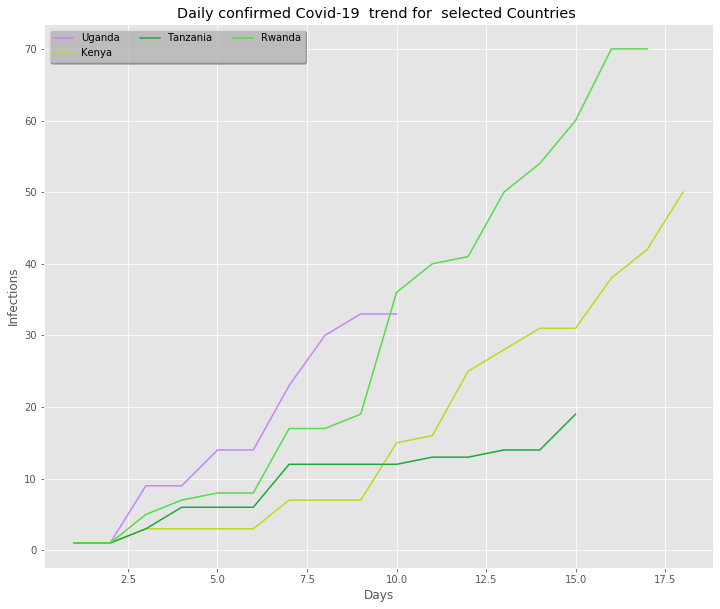

In [208]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Confirmed'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily confirmed Covid-19  trend for  selected Countries ')
    plt.ylabel("Infections")
    plt.xlabel("Days")
    leg.get_frame().set_alpha(0.5)
plt.savefig('confirmed.png')

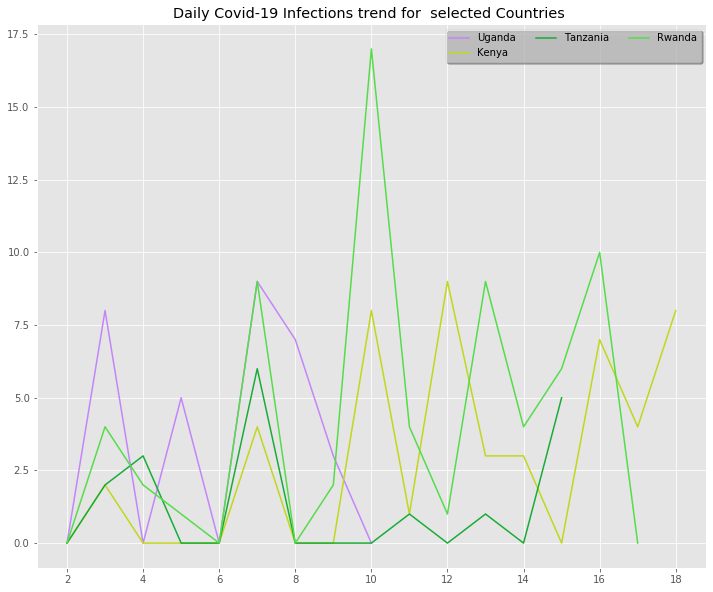

In [209]:
plt.figure(figsize=(12,10))
for i in range(0,len(list_top_df)):
    #list_top_df[i]
    plt.plot(list_top_df[i]['Days'],list_top_df[i]['Daily_Infection'],c= list_colors[i],label=countries[i])
    leg = plt.legend(loc='best', ncol=3 , shadow=True, fancybox=True)
    plt.title('Daily Covid-19 Infections trend for  selected Countries ')
    leg.get_frame().set_alpha(0.5)
plt.savefig('Daily_Infections.png')